c:\Users\KHALIL\anaconda3\envs\evforecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\KHALIL\anaconda3\envs\evforecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\KHALIL\anaconda3\envs\evforecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


c:\Users\KHALIL\anaconda3\envs\evforecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

📊 Forecasting Metrics Summary:

Horizon     RMSE      MAE      MSE
 7 days 0.210356 0.175177 0.044250
30 days 0.183317 0.146757 0.033605
60 days 0.221195 0.178453 0.048927
90 days 0.202551 0.152275 0.041027


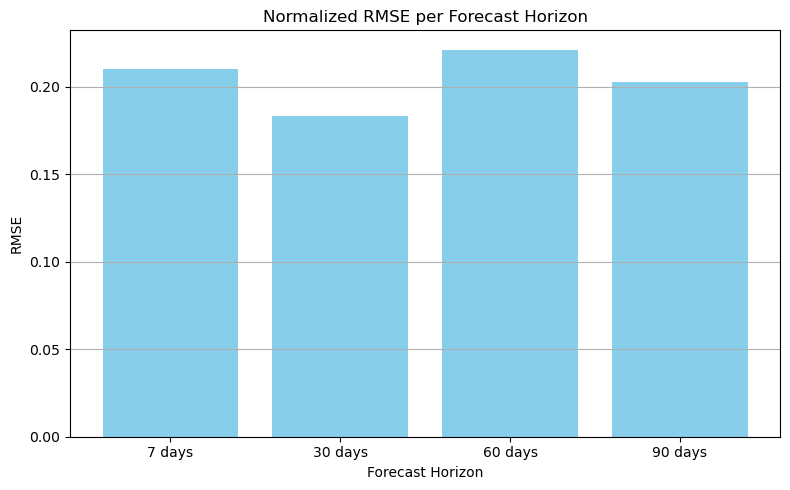

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# --- Load & preprocess data ---
df = pd.read_csv("../data/ev_energy_with_weather.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] <= '2021-12-28'].copy()
df.drop(columns=['snow_depth', 't_max', 't_min'], inplace=True)
df['weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
df['energy'] = df['energy'].rolling(window=3, min_periods=1).mean()
z_scores = ((df['energy'] - df['energy'].mean()) / df['energy'].std()).abs()
df = df[z_scores < 3].reset_index(drop=True)

# --- Lag features ---
df['energy_t-1'] = df['energy'].shift(1)
df['energy_t-2'] = df['energy'].shift(2)
df['energy_t-3'] = df['energy'].shift(3)
df['energy_t-7'] = df['energy'].shift(7)
df['rolling_std_7'] = df['energy'].rolling(window=7, min_periods=1).std().fillna(0)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Feature list ---
features = ['snow', 'weekend', 'energy', 'energy_t-1', 'energy_t-2', 'energy_t-3', 'energy_t-7', 'rolling_std_7']

# --- Create sequences function ---
def create_sequences(data, lookback, horizon, features):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X_seq = data[features].iloc[i:i+lookback].values
        y_seq = data['energy'].iloc[i+lookback:i+lookback+horizon].values
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# --- Run for multiple forecast horizons ---
lookback = 30
results = []

for horizon in [7, 30, 60, 90]:
    X_raw, y_raw = create_sequences(df, lookback, horizon, features)
    split = int(len(X_raw) * 0.8)
    X_train_raw, y_train_raw = X_raw[:split], y_raw[:split]
    X_test_raw, y_test_raw = X_raw[split:], y_raw[split:]
    
    # Normalize features
    X_train_flat = X_train_raw.reshape(-1, len(features))
    X_test_flat = X_test_raw.reshape(-1, len(features))
    x_scaler = MinMaxScaler()
    X_train_scaled = x_scaler.fit_transform(X_train_flat)
    X_test_scaled = x_scaler.transform(X_test_flat)
    X_train = X_train_scaled.reshape(X_train_raw.shape)
    X_test = X_test_scaled.reshape(X_test_raw.shape)

    # Normalize targets
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train_raw)
    y_test = y_scaler.transform(y_test_raw)

    # LSTM model
    model = Sequential()
    model.add(LSTM(128, input_shape=(lookback, len(features))))
    model.add(Dropout(0.05))
    model.add(Dense(horizon))
    model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({'Horizon': f'{horizon} days', 'RMSE': rmse, 'MAE': mae, 'MSE': mse})

# --- Display results ---
results_df = pd.DataFrame(results)
print("\n📊 Forecasting Metrics Summary:\n")
print(results_df.to_string(index=False))

# --- Optional: bar plot for RMSE ---
plt.figure(figsize=(8, 5))
plt.bar(results_df['Horizon'], results_df['RMSE'], color='skyblue')
plt.title("Normalized RMSE per Forecast Horizon")
plt.xlabel("Forecast Horizon")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [9]:
df.columns

Index(['date', 'energy', 't_max', 't_min', 'precip', 'snow', 'weekend',
       'energy_t-1', 'energy_t-2', 'energy_t-3', 'energy_t-7',
       'rolling_std_7'],
      dtype='object')

In [13]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.losses import MeanSquaredError, Huber
# from tensorflow.keras.callbacks import EarlyStopping

# # --- Preprocessing & Model Functions ---
# def preprocess_data(df, rolling_window):
#     df['energy'] = df['energy'].rolling(window=rolling_window, min_periods=1).mean()
#     z_scores = ((df['energy'] - df['energy'].mean()) / df['energy'].std()).abs()
#     df = df[z_scores < 3].reset_index(drop=True)
#     df['energy_t-1'] = df['energy'].shift(1)
#     df['energy_t-2'] = df['energy'].shift(2)
#     df['energy_t-3'] = df['energy'].shift(3)
#     df['energy_t-7'] = df['energy'].shift(7)
#     df['rolling_std_7'] = df['energy'].rolling(window=7, min_periods=1).std().fillna(0)
#     df.dropna(inplace=True)
#     df.reset_index(drop=True, inplace=True)
#     return df

# def create_sequences(data, lookback, horizon, features):
#     X, y = [], []
#     for i in range(len(data) - lookback - horizon + 1):
#         X_seq = data[features].iloc[i:i+lookback].values
#         y_seq = data['energy'].iloc[i+lookback:i+lookback+horizon].values
#         X.append(X_seq)
#         y.append(y_seq)
#     return np.array(X), np.array(y)

# def build_model(input_shape, horizon, optimizer_type, loss_type):
#     model = Sequential()
#     model.add(LSTM(128, input_shape=input_shape))
#     model.add(Dropout(0.2))
#     model.add(Dense(horizon))
    
#     optimizer = Adam(learning_rate=0.0003) if optimizer_type == 'adam' else RMSprop(learning_rate=0.0005)
#     loss = Huber() if loss_type == 'huber' else MeanSquaredError()
    
#     model.compile(optimizer=optimizer, loss=loss)
#     return model

# def evaluate_model(df, lookback, horizon, features, optimizer_type, loss_type, batch_size, rolling_window):
#     df_processed = preprocess_data(df.copy(), rolling_window)
#     scaler = MinMaxScaler()
#     df_processed['energy'] = scaler.fit_transform(df_processed[['energy']])
    
#     X_raw, y_raw = create_sequences(df_processed, lookback, horizon, features)
#     split = int(len(X_raw) * 0.8)
#     X_train_raw, y_train_raw = X_raw[:split], y_raw[:split]
#     X_test_raw, y_test_raw = X_raw[split:], y_raw[split:]
    
#     X_train_flat = X_train_raw.reshape(-1, len(features))
#     X_test_flat = X_test_raw.reshape(-1, len(features))
#     x_scaler = MinMaxScaler()
#     X_train_scaled = x_scaler.fit_transform(X_train_flat)
#     X_test_scaled = x_scaler.transform(X_test_flat)
#     X_train = X_train_scaled.reshape(X_train_raw.shape)
#     X_test = X_test_scaled.reshape(X_test_raw.shape)
    
#     y_scaler = MinMaxScaler()
#     y_train = y_scaler.fit_transform(y_train_raw)
#     y_test = y_scaler.transform(y_test_raw)
    
#     model = build_model((lookback, len(features)), horizon, optimizer_type, loss_type)
#     early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#     model.fit(X_train, y_train, epochs=200, batch_size=batch_size, validation_split=0.1, callbacks=[early_stop], verbose=0)
    
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     mae = mean_absolute_error(y_test, y_pred)
#     mse = mean_squared_error(y_test, y_pred)
#     return rmse, mae, mse

# # --- Load and Prepare Dataset ---
# df_base = pd.read_csv("../data/ev_energy_with_weather.csv")
# df_base['date'] = pd.to_datetime(df_base['date'])
# df_base = df_base[df_base['date'] <= '2021-12-28'].copy()
# df_base.drop(columns=['snow_depth'], inplace=True)
# df_base['weekend'] = (df_base['date'].dt.dayofweek >= 5).astype(int)

# # --- Grid Search Parameters ---
# lookback = 30
# horizon = 7
# features = ['snow', 'weekend', 'energy_t-1', 'energy_t-2', 'energy_t-3', 'energy_t-7', 'rolling_std_7']
# rolling_windows = [1, 3, 5, 7]
# batch_sizes = [16, 32, 64]
# optimizers = ['adam', 'rmsprop']
# losses = ['mse', 'huber']

# # --- Grid Search Execution ---
# results = []
# for roll in rolling_windows:
#     for batch in batch_sizes:
#         for opt in optimizers:
#             for loss in losses:
#                 rmse, mae, mse = evaluate_model(df_base, lookback, horizon, features, opt, loss, batch, roll)
#                 results.append({
#                     'Rolling': roll, 'Batch': batch, 'Optimizer': opt, 'Loss': loss,
#                     'RMSE': rmse, 'MAE': mae, 'MSE': mse
#                 })

# # --- Display Top 10 Configurations ---
# results_df = pd.DataFrame(results).sort_values(by='RMSE').reset_index(drop=True)
# print("\n🔍 Top 10 LSTM Configurations for K=7 (Sorted by RMSE):\n")
# print(results_df.head(10).to_string(index=False))
